# Data Wrangling (Limpieza de datos)  
## Actividad 7   
### Enunciado  
  1. Se debería realizar una limpieza de problemas (outliers, duplicados, valores nulos).  
  2. En caso de existir valores nulos decidir si se puede utilizar alguna técnica de imputación ya sea sensible o múltiple.  
  3. Se deberán resolver el problema de outliers, para esto se deberá generar una estrategia de identificación ya sea con métodos tradicionales (IQ, Z score, etc) o utilizando aprendizaje de máquina (Isolation Forest, LoF,SVM one Class, etc).

# Desarrollo

## Planificación
Se planea hacer una limpieza de datos usando la siguiente secuencia:  
    1. Se buscarán valores nulos  
    2. Se verificará el porcentaje de valores nulos.  
    3. Si la cantidad de valores nulos no es significativo, se descartarán dichos datos. Sino, se tratarán de llenar con algún método conocido.  
    4. Una vez tratados los nulos, se tratarán los outliers. 

### Diseño  
Los datos de interés para los futuros modelos serán los siguientes:  
Primera linea, variables con interés relacionadas a la retención del usuario:  
    - Score: Variable de interés principal  
    - Genres: Variable de comparación  
    - Producers: Variable de comparación  
    - Studios: Variable de comparación  
    - Ranked: Variable relevante  
    - Popularity: Variable relevante  
    - Rating: Variable relevante  
    - Favorites: Variable relevante  
    - Type: Variable relevante  
      
Segunda linea, variables con interés a la fidelidad del usuario y el tiempo dedicado:  
    - Score: Variable relevante  
    - Duration: Variable relevante  
    - Episodes: Variable relevante  
    - Watching: Variable relevante  
    - Completed: Variable relevante  
    - On-Hold: Variable relevante  
    - Dropped: Variable relevante  


## Desarrollo técnico

### Inicialización

In [1]:
import warnings
import pandas as pd
#import missingno as msn 
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
import math

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


In [2]:
#Lectura del archivo y confirmación de contenido

tabla=pd.read_csv('anime.csv',sep=',',encoding='utf-8')
tabla.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [3]:
#Separación de los datos de interés 
data1 = tabla[['Name','Score', 'Genres', 'Producers', 'Studios','Ranked','Popularity','Rating','Favorites','Type']].copy()
data2 = tabla[['Name','Score', 'Duration', 'Episodes', 'Watching','Completed','On-Hold','Dropped']].copy()

Tomado de actividades anteriores para el procesamiento de los datos. 

In [4]:
warnings.filterwarnings("ignore")
#Primera linea 
#Pasando de lista separada por comas a listas estructuradas
def deconstruir(line): #Linea base
  if (line == 'Unknown'): #Si es desconocido se deja igual. 
      return 'Unknown'
  else:
    temp = line.split(",") #Se separa en una lista separada por comas
    return temp

#Procesando
for i in range(len(data1)): #por cada fila
  data1['Genres'][i] = deconstruir(data1['Genres'][i])
  data1['Producers'][i] = deconstruir(data1['Producers'][i])
  data1['Studios'][i] = deconstruir(data1['Studios'][i])

In [5]:
warnings.filterwarnings("ignore")
#Segunda linea
#Método para procesar el tiempo de duración a float
def procesarDateToFloat(line, episodes): #Se recibe la linea base a procesar y la cantidad de episodios
  if (line == 'Unknown'): #Si es desconocido, se deja igual. 
      return 'Unknown'
  else:
      if (episodes == 'Unknown'): #Si no se sabe cuantos episodios tuvo
          epis = 0 #Se asume que tuvo al menos uno
      else: #Sino 
          epis = int(episodes) #Se usa el número de episodios
      #Deconstruimos si es necesario entre los que se encuentren
      dur = line.split(" ")
      duration = 0 #Variable para colocar la duración en minutos
            #Hay varios casos aquí: 
            #1 Cuando es en segundos "x sec."
            #2 Cuando es en segundos por episodios "x sec. per ep."
            #3 Cuando es en minutos "x min."
            #4 Cuando es en minutos por episodios "x min. per ep."
            #5 Cuando es en horas "x hr."
            #6 Cuando es en horas y minutos "x hr. x min."

      if dur[1] == "sec.": #Si es por segundos
            duration = float(dur[0]) / 60 #Se divide el valor en 60 para volverlo minutos. 
            #Queda validado caso 1
      elif dur[1] == "min.": #Sino, se valida si es por minutos
            duration = float(dur[0]) #Se deja el valor en minutos
            #Queda validado caso 3
      else: #Sino, es por horas
            duration = float(dur[0]) * 60 #Se multiplica el valor por 60 para volverlo minutos
            #Queda validado caso 5

      if len(dur) > 2: #Si el tamaño es mayor a 2, es porque es una duración compuesta
            if dur[-1] == "ep.": #Si se divide por episodios, se validan casos 2 y 4
                  duration = duration * epis #Se multiplica por la cantidad de episodios
                  #Quedan validados casos 2 y 4
            elif dur[-1] == "min.": #Si se divide en horas y minutos, se valida caso 6
                  duration = duration + float(dur[2]) #Se suman los minutos
      return duration
  
for i in range(len(data2)): #Por cada fila
     data2['Duration'][i] = procesarDateToFloat(data2['Duration'][i], data2['Episodes'][i])

Para la primera linea: Ahora se tienen los valores categoricos en una lista estructurada para trabajar mejor.  
Para la segunda linea: Ahora se tiene la duración total del anime en minutos. 

### Nulos

In [6]:
#Se verifica que no tenga nulos
print('Primera linea:')
print(data1.isnull().sum())
print('Segunda linea:')
print(data2.isnull().sum())

Primera linea:
Name          0
Score         0
Genres        0
Producers     0
Studios       0
Ranked        0
Popularity    0
Rating        0
Favorites     0
Type          0
dtype: int64
Segunda linea:
Name         0
Score        0
Duration     0
Episodes     0
Watching     0
Completed    0
On-Hold      0
Dropped      0
dtype: int64


Sin embargo, gracias al análisis exploratorio de datos, se sabe que no hay valores nulos, pero si se encuentran valores "unknown". En el caso actual, serian equivalentes. Por lo tanto, hay que trabajar los datos unknown. 

In [7]:
nulos = data1.apply(lambda row: row.astype(str).str.contains('Unknown').any(), axis=1).sum()
print('Cantidad de filas que presentan nulos: '+str(nulos))
print('Porcentaje de filas que presentan nulos:')
print((nulos/len(data1))*100)

Cantidad de filas que presentan nulos: 12190
Porcentaje de filas que presentan nulos:
69.41122878943172


In [8]:
nulos = data2.apply(lambda row: row.astype(str).str.contains('Unknown').any(), axis=1).sum()
print('Cantidad de filas que presentan nulos: '+str(nulos))
print('Porcentaje de filas que presentan nulos:')
print((nulos/len(data1))*100)

Cantidad de filas que presentan nulos: 5266
Porcentaje de filas que presentan nulos:
29.985195308051477


En ambos casos es un porcentaje considerable, por lo que no es bueno perder tanta información.  
Se procede a reemplazar los datos.  
Se escogido **la imputación multiple o predictiva** porque son demasiados nulos. Los datos serán sometidos ambos a los métodos de Knn imputation y Mice Imputation.   

¿Donde se encuentran exactamente estos nulos disfrazados de Unknown? 

In [9]:
null = {} #Se crea diccionario para almacenar los unknowns
for i in data1.columns: #Por cada columna
    null[i] = int((data1[i].values == 'Unknown').sum()) #Se obtiene la cantidad de Unknowns
print(null)

{'Name': 0, 'Score': 5141, 'Genres': 63, 'Producers': 7794, 'Studios': 7079, 'Ranked': 1762, 'Popularity': 0, 'Rating': 688, 'Favorites': 0, 'Type': 37}


In [10]:
null = {} #Se crea diccionario para almacenar los unknowns
for i in data2.columns: #Por cada columna
    null[i] = int((data2[i].values == 'Unknown').sum()) #Se obtiene la cantidad de Unknowns
print(null)

{'Name': 0, 'Score': 5141, 'Duration': 555, 'Episodes': 516, 'Watching': 0, 'Completed': 0, 'On-Hold': 0, 'Dropped': 0}


#### Segunda linea

Para la segunda linea se va a tomar los valores 'Unknown' y volvernos valores nulos para poder trabajar adecuadamente con ellos. 

In [11]:
for i in data1.columns: #Por cada columna
    data1[i] = data1[i].apply(lambda x: x if x != 'Unknown' else np.nan) #Se cambia los valores Unknown por NaN

In [12]:
for i in data2.columns: #Por cada columna
    data2[i] = data2[i].apply(lambda x: x if (x != 'Unknown') else np.nan) #Se cambia los valores Unknown por NaN
    data2[i] = data2[i].apply(lambda x: x if (x != 0) else np.nan) #Se cambia los valores 0 por NaN

In [13]:
data1.isnull().sum() #Ver los nulos de las filas

Name             0
Score         5141
Genres          63
Producers     7794
Studios       7079
Ranked        1762
Popularity       0
Rating         688
Favorites        0
Type            37
dtype: int64

In [14]:
data2.isnull().sum() #Ver los nulos de las filas

Name            0
Score        5141
Duration      555
Episodes      516
Watching      357
Completed     531
On-Hold       871
Dropped       376
dtype: int64

Ahora si podemos trabajar con valores nulos. 

Text(0.5, 1.0, 'Modificacion')

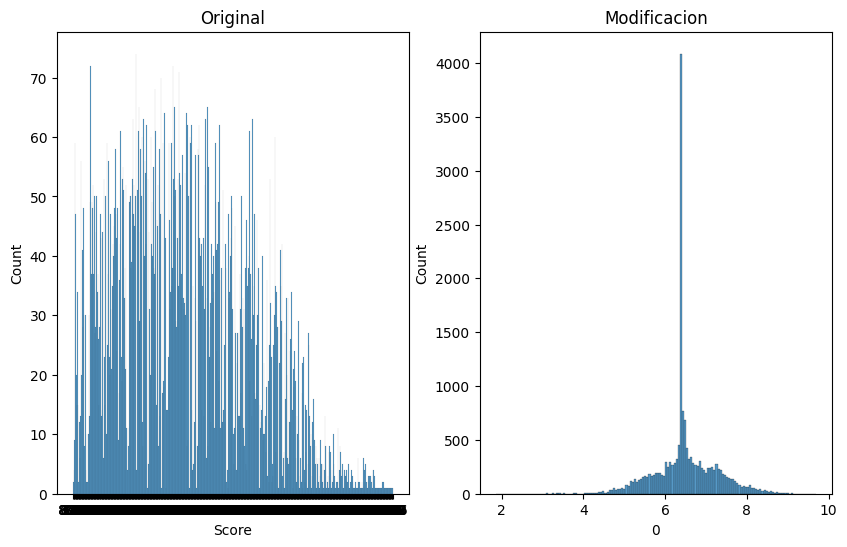

In [15]:
#Imputación multiple para la segunda linea
mice_impute = IterativeImputer()
data2fill = mice_impute.fit_transform(data2[['Score','Duration','Episodes','Watching','Completed','On-Hold','Dropped']])
data2fillDF= pd.DataFrame(data2fill)

# Verificar si cambiamos distribucion
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.histplot(data2['Score'])
plt.title('Original')
plt.subplot(122)
sns.histplot(data2fillDF[0])
plt.title('Modificacion')

Es muy diferente la distribución. Este llenado no es viable. 

Probemos ahora con imputación multiple KNN

Text(0.5, 1.0, 'Modificacion')

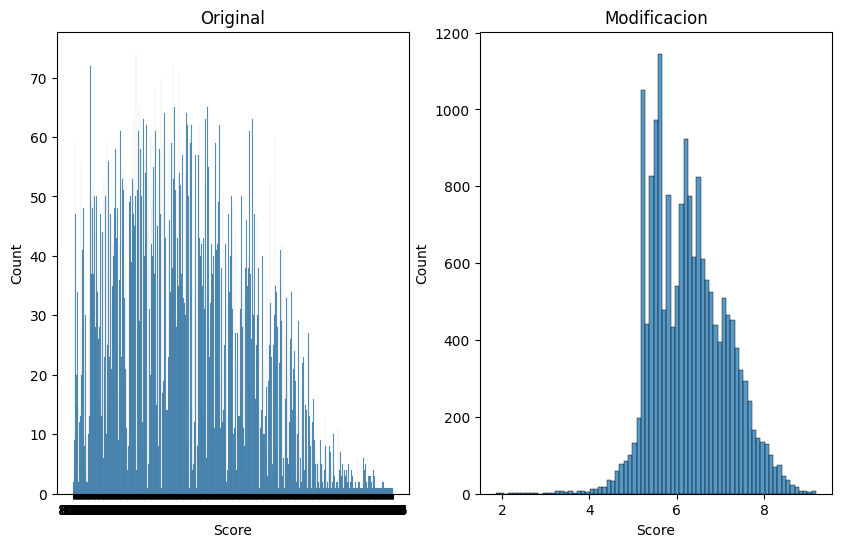

In [16]:
imputer = KNNImputer(n_neighbors= 3).set_output(transform='pandas')
data2f = imputer.fit_transform(data2.drop('Name', axis=1))

# Verificar si cambiamos distribucion
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.histplot(data2['Score'])
plt.title('Original')
plt.subplot(122)
sns.histplot(data2f['Score'])
plt.title('Modificacion')

Es más coherente que el anterior. 

In [17]:
data2f['Name'] = data2['Name'] #Se agrega la columna de nombres

In [18]:
#Se elimina la parte entera de aquellas categorías que así lo requieran
for i in range(len(data2f)):
    data2f['Duration'][i]=math.trunc(data2f['Duration'][i])
    data2f['Episodes'][i]=math.trunc(data2f['Episodes'][i])
    data2f['Completed'][i]=math.trunc(data2f['Completed'][i])
    data2f['Dropped'][i]=math.trunc(data2f['Dropped'][i])
    data2f['On-Hold'][i]=math.trunc(data2f['On-Hold'][i])
    data2f['Watching'][i]=math.trunc(data2f['Watching'][i])

In [19]:
#Se confirma que los datos estén llenos
data2f.tail(4)

,Score,Duration,Episodes,Watching,Completed,On-Hold,Dropped,Name
17558,5.676667,2140.0,425.0,14.0,132.0,14.0,57.0,Mieruko-chan
17559,5.993333,17.0,1.0,3.0,33.0,2.0,19.0,Higurashi no Naku Koro ni Sotsu
17560,5.493333,130.0,4.0,13.0,2.0,2.0,1.0,Yama no Susume: Next Summit
17561,6.563333,9.0,1.0,4.0,24.0,1.0,1.0,Scarlet Nexus


Ahora tenemos el dataframe de la segunda linea sin valores nulos. Listo para pasar a los Outliers

#### Primera linea

Para el caso de la primera linea, va a ser un poco distinto.  
Las columnas de **Genres, Producers y Studios** constan de estructuras de datos con los asociados a un anime. Por lo tanto, se va a expandir el dataframe para poder hacer una implantación multiple de los datos.  
El proceso será el siguiente:  
    1. Se llenarán los nulos de las categorías **Type, Rating y Ranked**  
    2. Se multiplicarán las filas por categorías **Genres, Producers y Studios**  
    3. Se hará la implantación multiple.  

In [20]:
print('Type')
print(data1['Type'].unique())
print('Rating')
print(data1['Rating'].unique())

Type
['TV' 'Movie' 'OVA' 'Special' 'ONA' 'Music' nan]
Rating
['R - 17+ (violence & profanity)' 'PG-13 - Teens 13 or older'
 'PG - Children' 'R+ - Mild Nudity' 'G - All Ages' 'Rx - Hentai' nan]


Se van a convertir las categorías **Type y Rating** a valores ordinales teniendo en cuenta la duración promedio del producto y la gravedad del contenido correspondientemente. 

In [21]:
for i in range(len(data1)):
    if data1['Rating'][i] == 'G - All Ages':
        data1['Rating'][i] = 0
    elif data1['Rating'][i] == 'PG - Children':
        data1['Rating'][i] = 1
    elif data1['Rating'][i] == 'PG-13 - Teens 13 or older':
        data1['Rating'][i] = 2
    elif data1['Rating'][i] == 'R - 17+ (violence & profanity)':
        data1['Rating'][i] = 3
    elif data1['Rating'][i] == 'R+ - Mild Nudity':
        data1['Rating'][i] = 4
    elif data1['Rating'][i] == 'Rx - Hentai':
        data1['Rating'][i] = 5
    else:
        data1['Rating'][i] = data1['Rating'][i]

In [22]:
for i in range(len(data1)):
    if data1['Type'][i] == 'Music':
        data1['Type'][i] = 0
    elif data1['Type'][i] == 'Special':
        data1['Type'][i] = 1
    elif data1['Type'][i] == 'OVA':
        data1['Type'][i] = 2
    elif data1['Type'][i] == 'Movie':
        data1['Type'][i] = 3
    elif data1['Type'][i] == 'ONA':
        data1['Type'][i] = 4
    elif data1['Type'][i] == 'TV':
        data1['Type'][i] = 5
    else:
        data1['Type'][i] = data1['Type'][i]

Ahora a llenar los nulos

Text(0.5, 1.0, 'Modificacion')

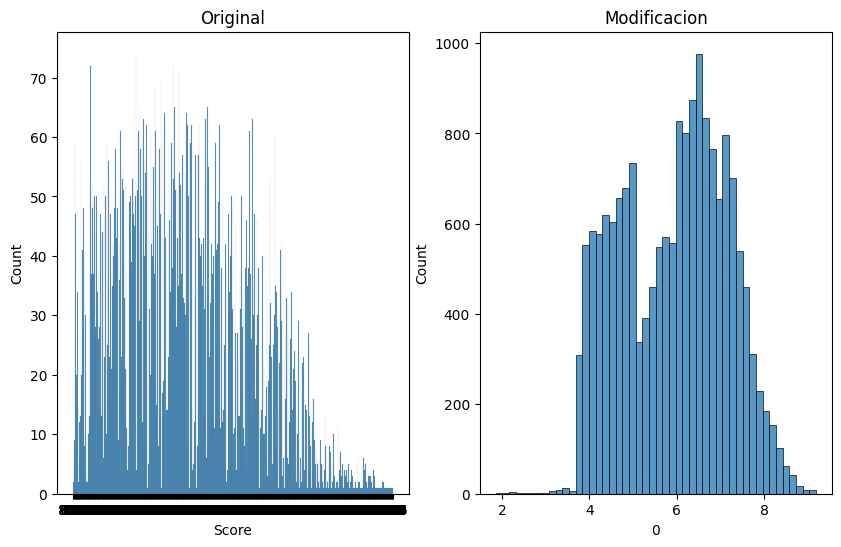

In [23]:
#Imputación multiple para la primera linea
mice_impute = IterativeImputer()
data1fill = mice_impute.fit_transform(data1[['Score','Ranked','Popularity','Rating','Favorites','Type']])
data1fillDF= pd.DataFrame(data1fill)

# Verificar si cambiamos distribucion
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.histplot(data1['Score'])
plt.title('Original')
plt.subplot(122)
sns.histplot(data1fillDF[0])
plt.title('Modificacion')

Text(0.5, 1.0, 'Modificacion')

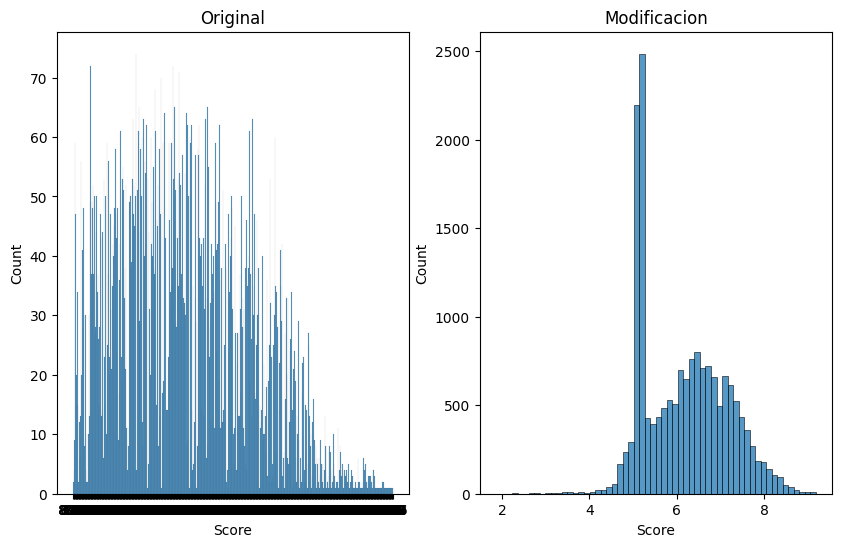

In [24]:
imputer = KNNImputer(n_neighbors= 3).set_output(transform='pandas')
data1f = imputer.fit_transform(data1.drop(['Name','Genres','Producers','Studios'], axis=1))

# Verificar si cambiamos distribucion
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.histplot(data1['Score'])
plt.title('Original')
plt.subplot(122)
sns.histplot(data1f['Score'])
plt.title('Modificacion')

En el caso de la primera linea, es mejor el método Mice.  

Preparamos el dataframe a usar. 

In [25]:
data1fillDF = data1fillDF.rename(columns={0: 'Score',1: 'Ranked',2: 'Popularity',3: 'Rating',4: 'Favorites',5: 'Type'})
data1fillDF.head(2)

,Score,Ranked,Popularity,Rating,Favorites,Type
0,8.78,28.0,39.0,3.0,61971.0,5.0
1,8.39,159.0,518.0,3.0,1174.0,3.0


In [26]:
print('Rating')
print(data1fillDF['Rating'].value_counts().tail(5))
print('Type')
print(data1fillDF['Type'].value_counts().tail(5))

Rating
Rating
-0.181009    1
 0.116028    1
 0.733878    1
-0.181108    1
 0.856348    1
Name: count, dtype: int64
Type
Type
2.721141    1
2.102010    1
1.706397    1
2.681607    1
2.435614    1
Name: count, dtype: int64


In [27]:
#Eliminando los valores no enteros de Type y Ranting
#Adicionalmente se eliminan los valores decimales de Ranked, se repetirán posiciones
for i in range(len(data1fillDF)):
    data1fillDF['Rating'][i]=math.trunc(data1fillDF['Rating'][i])
    data1fillDF['Type'][i]=math.trunc(data1fillDF['Type'][i])
    data1fillDF['Ranked'][i]=math.trunc(data1fillDF['Ranked'][i])

In [28]:
#Confirmando que solo hayan valores no decimales
print('Rating')
print(data1fillDF['Rating'].value_counts())
print('Type')
print(data1fillDF['Type'].value_counts())

Rating
Rating
2.0    6229
0.0    6078
1.0    1752
5.0    1345
3.0    1161
4.0     997
Name: count, dtype: int64
Type
Type
5.0    4996
2.0    3912
3.0    3059
1.0    2219
4.0    1907
0.0    1469
Name: count, dtype: int64


In [29]:
#Fusionando dataframes
data1fillDF['Name'] = data1['Name']
data1fillDF['Genres'] = data1['Genres']
data1fillDF['Producers'] = data1['Producers']
data1fillDF['Studios'] = data1['Studios']
data1fillDF.head(2)

,Score,Ranked,Popularity,Rating,Favorites,Type,Name,Genres,Producers,Studios
0,8.78,28.0,39.0,3.0,61971.0,5.0,Cowboy Bebop,"[Action, Adventure, Comedy, Drama, Sci-Fi,...",[Bandai Visual],[Sunrise]
1,8.39,159.0,518.0,3.0,1174.0,3.0,Cowboy Bebop: Tengoku no Tobira,"[Action, Drama, Mystery, Sci-Fi, Space]","[Sunrise, Bandai Visual]",[Bones]


Ahora a dividir la información. Los nulos y Unknown se encuentran en **Genres, Producers y Studios**

In [30]:
data1fillDF.isnull().sum()

Score            0
Ranked           0
Popularity       0
Rating           0
Favorites        0
Type             0
Name             0
Genres          63
Producers     7794
Studios       7079
dtype: int64

Vamos a extraer en un dataframe, la lista de los Géneros, Productores y Studio. Una vez con el dataframe, se podrá trabajar con los indices correspondientes de cada fila para relacionarlos a cada uno.  
Esto se hace con el fin de volver las columnas **Genre, Producers, Studios** de categóricas a ordinales. Se puede considerar que son categorías porque se repiten entre sí y ayudan a clasificar la información. 

In [31]:
#Sacando lista de los productores para experimentar
#Sacando información de Genres, Producers, Studios.

warnings.filterwarnings("ignore")
#Método que procesa el dataframe para no repetir código
def deconstruir(dataframe, column, line): #Se recibe dataframe objetivo, columna a procesar y linea base
  if type(line) != float: #Si no es nulo
    for item in line: #Por cada categoría del registro
      if ((dataframe == item).any().any()) == False: #Si no se encuentra
          dataframe = pd.concat([dataframe, pd.DataFrame([{column : item }])], ignore_index=True) #Se agrega
  return dataframe


#Se trabajará con dataframe para almacenar los datos de interés para las tres categorías
producerdf = pd.DataFrame(columns=['Producer'])
genredf = pd.DataFrame(columns=['Genre'])
studiodf = pd.DataFrame(columns=['Studio'])

#Para cada uno de los registros
for i in range(len(data1fillDF)):
    producerdf = deconstruir(producerdf, 'Producer', data1fillDF['Producers'][i])
    genredf = deconstruir(genredf, 'Genre', data1fillDF['Genres'][i])
    studiodf = deconstruir(studiodf, 'Studio', data1fillDF['Studios'][i])


Ahora vamos a multiplicar las filas por estas categorías de la siguiente manera:  
- Se van a multiplicar las filas a excepción de los productores, que se van a almacenar en el nuevo dataframe con números correspondientes a las filas del dataframe **producerdf**. Es decir, si un anime pertenece a 4 productores, habrán ahora 4 filas de ese anime con productores distintos.
- Se repite este mismo proceso con el dataframe resultante, esta vez con **Genres**
- Se repite este mismo proceso con el dataframe resultante, esta vez con **Studios**

In [32]:
bigdata1 = pd.DataFrame(columns=['Score', 'Ranked', 'Popularity', 'Rating', 'Favorites', 'Type', 'Name',
       'Genres', 'Producers', 'Studios'])
bigdata2 = pd.DataFrame(columns=['Score', 'Ranked', 'Popularity', 'Rating', 'Favorites', 'Type', 'Name',
       'Genres', 'Producers', 'Studios'])
bigdata3 = pd.DataFrame(columns=['Score', 'Ranked', 'Popularity', 'Rating', 'Favorites', 'Type', 'Name',
       'Genres', 'Producers', 'Studios'])

In [33]:
for i in range(len(data1fillDF)): #Por cada fila
#for i in range(20): #Por cada fila existtente
    #Productores
    if type(data1fillDF['Producers'][i]) != float: #Si no es nulo
        for j in data1fillDF['Producers'][i]: #Por cada productor de la fila existente
            temp = int(np.where(producerdf["Producer"] == j)[0]) #Se saca el index
            bigdata1 = pd.concat([bigdata1, pd.DataFrame([{'Score': data1fillDF['Score'][i], 'Ranked': data1fillDF['Ranked'][i], 'Popularity': data1fillDF['Popularity'][i], 
                    'Rating': data1fillDF['Rating'][i], 'Favorites': data1fillDF['Favorites'][i], 'Type': data1fillDF['Type'][i], 'Name': data1fillDF['Name'][i],
                    "Producers" : temp, 'Genres': data1fillDF['Genres'][i], 'Studios' : data1fillDF['Studios'][i]}])], ignore_index=True) #Se agrega
    else: #Si es nulo se deja todo normal
        bigdata1 = pd.concat([bigdata1, pd.DataFrame([{'Score': data1fillDF['Score'][i], 'Ranked': data1fillDF['Ranked'][i], 'Popularity': data1fillDF['Popularity'][i], 
                    'Rating': data1fillDF['Rating'][i], 'Favorites': data1fillDF['Favorites'][i], 'Type': data1fillDF['Type'][i], 'Name': data1fillDF['Name'][i],
                    "Producers" : data1fillDF['Producers'][i], 'Genres': data1fillDF['Genres'][i], 'Studios' : data1fillDF['Studios'][i]}])], ignore_index=True) #Se agrega
    

for i in range(len(bigdata1)): #Por cada fila
#for i in range(20): #Por cada fila nueva
    #Generos
    if type(bigdata1['Genres'][i]) != float: #Si no es nulo
        for j in bigdata1['Genres'][i]: #Por cada genero de la fila existente
            temp = int(np.where(genredf["Genre"] == j)[0]) #Se saca el index
            bigdata2 = pd.concat([bigdata2, pd.DataFrame([{'Score': bigdata1['Score'][i], 'Ranked': bigdata1['Ranked'][i], 'Popularity': bigdata1['Popularity'][i], 
                    'Rating': bigdata1['Rating'][i], 'Favorites': bigdata1['Favorites'][i], 'Type': bigdata1['Type'][i], 'Name': bigdata1['Name'][i],
                    "Genres" : temp, 'Producers': bigdata1['Producers'][i], 'Studios' : bigdata1['Studios'][i]}])], ignore_index=True) #Se agrega
    else: #Si es nulo se deja todo igual 
        bigdata2 = pd.concat([bigdata2, pd.DataFrame([{'Score': bigdata1['Score'][i], 'Ranked': bigdata1['Ranked'][i], 'Popularity': bigdata1['Popularity'][i], 
                    'Rating': bigdata1['Rating'][i], 'Favorites': bigdata1['Favorites'][i], 'Type': bigdata1['Type'][i], 'Name': bigdata1['Name'][i],
                    "Genres" : bigdata1['Genres'][i], 'Producers': bigdata1['Producers'][i], 'Studios' : bigdata1['Studios'][i]}])], ignore_index=True) #Se agrega

#Studio
for i in range(len(bigdata2)): #Por cada fila
#for i in range(20): #Por cada fila nueva
    if type(bigdata2['Studios'][i]) != float: #Si no es nulo
        for j in bigdata2['Studios'][i]: #Por cada productor de la fila existente
            temp = int(np.where(studiodf["Studio"] == j)[0]) #Se saca el index
            bigdata3 = pd.concat([bigdata3, pd.DataFrame([{'Score': bigdata2['Score'][i], 'Ranked': bigdata2['Ranked'][i], 'Popularity': bigdata2['Popularity'][i], 
                    'Rating': bigdata2['Rating'][i], 'Favorites': bigdata2['Favorites'][i], 'Type': bigdata2['Type'][i], 'Name': bigdata2['Name'][i],
                    "Studios" : temp, 'Genres': bigdata2['Genres'][i], 'Producers' : bigdata2['Producers'][i]}])], ignore_index=True) #Se agrega
    else: #Si es nulo, se deja todo igual
            bigdata3 = pd.concat([bigdata3, pd.DataFrame([{'Score': bigdata2['Score'][i], 'Ranked': bigdata2['Ranked'][i], 'Popularity': bigdata2['Popularity'][i], 
                    'Rating': bigdata2['Rating'][i], 'Favorites': bigdata2['Favorites'][i], 'Type': bigdata2['Type'][i], 'Name': bigdata2['Name'][i],
                    "Studios" : bigdata2['Studios'][i], 'Genres': bigdata2['Genres'][i], 'Producers' : bigdata2['Producers'][i]}])], ignore_index=True) #Se agrega
        

Se confirma que la información este llena y bien distribuida, a excepción de los nulos (Genres, Producers, Studios). 

In [34]:
bigdata3.head(3)

,Score,Ranked,Popularity,Rating,Favorites,Type,Name,Genres,Producers,Studios
0,8.78,28.0,39.0,3.0,61971.0,5.0,Cowboy Bebop,0,0,0
1,8.78,28.0,39.0,3.0,61971.0,5.0,Cowboy Bebop,1,0,0
2,8.78,28.0,39.0,3.0,61971.0,5.0,Cowboy Bebop,2,0,0


In [35]:
bigdata3.tail(3)

,Score,Ranked,Popularity,Rating,Favorites,Type,Name,Genres,Producers,Studios
96946,4.115130,14564.0,17565.0,2.0,2.0,5.0,Yama no Susume: Next Summit,2,1503,402
96947,4.193093,14287.0,17563.0,0.0,0.0,5.0,Scarlet Nexus,0,1773,0
96948,4.193093,14287.0,17563.0,0.0,0.0,5.0,Scarlet Nexus,12,1773,0


Se confirma la presencia de los nulos. 

In [36]:
bigdata3.isnull().sum()

Score             0
Ranked            0
Popularity        0
Rating            0
Favorites         0
Type              0
Name              0
Genres           69
Producers     20583
Studios       16489
dtype: int64

Ahora tenemos un dataframe con todos los datos individuales en formato numérico. Ahora si es hora de llenar los nulos. 

Text(0.5, 1.0, 'Modificacion')

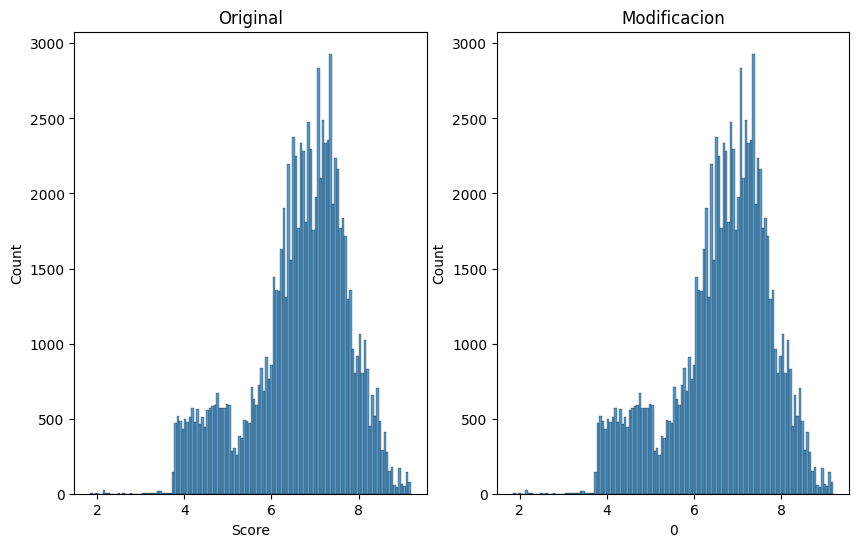

In [37]:
#Imputación multiple para la primera linea
mice_impute = IterativeImputer()
Data = mice_impute.fit_transform(bigdata3.drop(['Name'], axis=1))
Data1MI= pd.DataFrame(Data)

# Verificar si cambiamos distribucion
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.histplot(bigdata3['Score'])
plt.title('Original')
plt.subplot(122)
sns.histplot(Data1MI[0])
plt.title('Modificacion')

Text(0.5, 1.0, 'Modificacion')

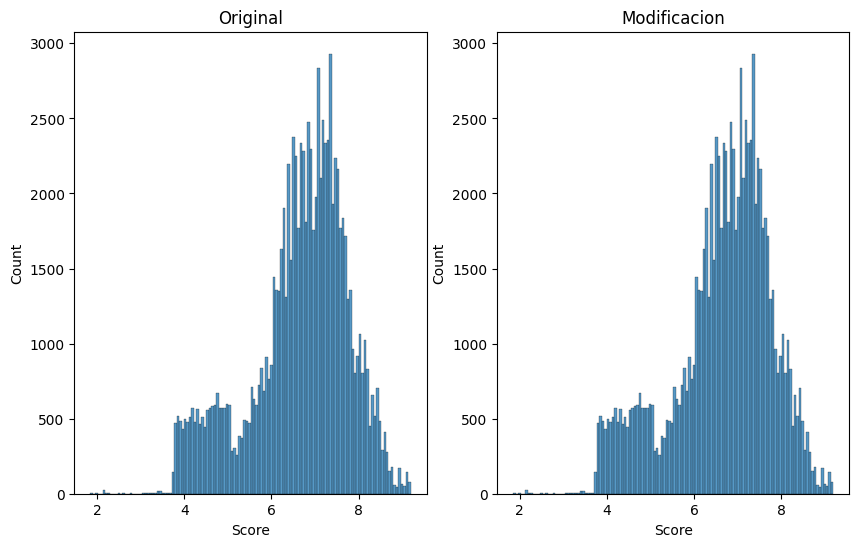

In [38]:
imputer = KNNImputer(n_neighbors= 3).set_output(transform='pandas')
Data1KNN = imputer.fit_transform(bigdata3.drop(['Name'], axis=1))

# Verificar si cambiamos distribucion
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.histplot(bigdata3['Score'])
plt.title('Original')
plt.subplot(122)
sns.histplot(Data1KNN['Score'])
plt.title('Modificacion')

Ambos casos mantuvieron la distribución. Se va a usar el primero.

In [39]:
#Se agregan los nombres correspondientes y los nombres de los animes
Data1MI = Data1MI.rename(columns={0: 'Score',1: 'Ranked',2: 'Popularity',3: 'Rating',4: 'Favorites',5: 'Type',6:'Genres',7:'Producers',8:'Studios'})
Data1MI['Name'] = bigdata3['Name']
Data1MI.tail(2)

,Score,Ranked,Popularity,Rating,Favorites,Type,Genres,Producers,Studios,Name
96947,4.193093,14287.0,17563.0,0.0,0.0,5.0,0.0,1773.0,0.0,Scarlet Nexus
96948,4.193093,14287.0,17563.0,0.0,0.0,5.0,12.0,1773.0,0.0,Scarlet Nexus


In [40]:
#Eliminando los valores no enteros 
for i in range(len(Data1MI)):
    Data1MI['Genres'][i]=math.trunc(Data1MI['Genres'][i])
    Data1MI['Producers'][i]=math.trunc(Data1MI['Producers'][i])
    Data1MI['Studios'][i]=math.trunc(Data1MI['Studios'][i])

In [41]:
#Ya tenemos los nulos resueltos
Data1MI.isnull().sum()

Score         0
Ranked        0
Popularity    0
Rating        0
Favorites     0
Type          0
Genres        0
Producers     0
Studios       0
Name          0
dtype: int64

### Outliers

Se van a analizar los siguientes modelos para decidir cuál es el más apto a la hora de identificar datos atípicos:  
- Isolation Forest  
- Minimum Covariance Determinant  
- Local Outlier Factor  
- One-Class SVM  

In [42]:
#Preparando dataframe para comparación
modelResultParameters = pd.DataFrame(columns=['Name','MAE','Size','Outliers'])
modelResultParameters['Name'] = ['Original','IsolationForest','MinimumCovarianceDeterminant','LocalOutlierFactor','One-ClassSVM']

Métodos de interes para evitar repetición de código. 

In [43]:
def MAE (column, data, yhat): #Método para filtrar los errores MAE el una vez con el modelo
    #Recibe la columna de interés, el dataframe base y la lista de outliers
    # seleccionar todas las filas que no son outliers
    mask = yhat == -1 # filtro

    filterX=data.copy() #Creando dataframe para guia
    filterX['Pass']=mask #Agregando fila para el filtro
    FilterX=filterX.copy()#Creando dataframe para datos sin outliers
    FilterY=y_train.copy()#Creando dataframe para datos sin outliers
    for index, row in filterX.iterrows(): #por cada fila
        if (row['Pass']): #Si es un outlier
            FilterX = FilterX.drop(index) #Se elimina esa fila
            FilterY = FilterY.drop(index) #Y en el vector objetivo también
    FilterX = FilterX.drop ('Pass', axis = 1) #Se elimina la fila de Pass

    X_train_i, y_train_i = FilterX, FilterY
    # Ajustar modelo
    model = LinearRegression()
    model.fit(X_train_i, y_train_i)
    # evaluar el modelo
    yhat_i = model.predict(X_test)
    # evaluar predicciones
    mae = mean_absolute_error(y_test, yhat_i)
    print(column)
    print('MAE: %.3f' % mae)

    #Agregando a dataframe
    ind = int(modelResultParameters.loc[modelResultParameters['Name'] == column].index[0])
    modelResultParameters['MAE'][ind] = mae

    

In [44]:
def filtrarDataframe (column, data, yhat): #Método para filtrar el dataframe una vez con el modelo
    #Recibe nombre de la columna, dataframe base y array de outliers
    # seleccionar filas que no son outliers
    mask = yhat == -1
    filter=data.copy() #Creando dataframe para guia
    Filtered=filter.copy()#Creando dataframe para datos sin outliers
    filter['Pass']=mask #Agregando fila para el filtro
    for index, row in filter.iterrows(): #por cada fila
        if (row['Pass']): #Si es un outlier
            Filtered = Filtered.drop(index) #Se elimina esa fila

    #Agregando a dataframe 
    ind = int(modelResultParameters.loc[modelResultParameters['Name'] == column].index[0])
    modelResultParameters['Size'][ind] = len(Filtered)
    modelResultParameters['Outliers'][ind] = list(mask).count(True)
    return Filtered #Retorna el dataframe filtrado

#### Primera linea

In [45]:
#Separar en X y y
x, y = Data1MI.drop(['Name','Score'], axis=1),Data1MI['Score']
# separar en train y test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

# ajustar modelo
model = LinearRegression()
model.fit(X_train, y_train)
# obtener predicciones
yhat = model.predict(X_test)
# evaluar predicciones
mae = mean_absolute_error(y_test, yhat)
print("Error sin haber considerado atípicos:")
print('MAE: %.3f' % mae)

Error sin haber considerado atípicos:
MAE: 0.102


In [46]:
#Se prepara el dataframe para exponer los parametros
ind = int(modelResultParameters.loc[modelResultParameters['Name'] == 'Original'].index[0])
modelResultParameters['MAE'][ind] = mae
modelResultParameters['Size'][ind] = len(Data1MI)
modelResultParameters['Outliers'][ind] = 0

In [47]:
#LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20,algorithm='auto',metric='minkowski')
yhat = lof.fit_predict(X_train)
MAE('LocalOutlierFactor', X_train, yhat)

# IsolationForest
iso = IsolationForest(contamination=0.1) # contamination = proporcion de outliers esperada
yhat = iso.fit_predict(X_train)
MAE('IsolationForest', X_train, yhat)

#One-ClassSVM
ee = OneClassSVM(nu=0.1) # nu proporcion de outliers
yhat = ee.fit_predict(X_train)
MAE('One-ClassSVM', X_train, yhat)

#MinimumCovarianceDeterminant
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(X_train)
MAE('MinimumCovarianceDeterminant', X_train, yhat)

LocalOutlierFactor
MAE: 0.101
IsolationForest
MAE: 0.102
One-ClassSVM
MAE: 0.108
MinimumCovarianceDeterminant
MAE: 0.127


Ahora se van a aplicar al los datos. 

In [48]:
#LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20,algorithm='auto',metric='minkowski')
yhat = lof.fit_predict(Data1MI.drop(['Name'], axis=1))
FilteredLOF = filtrarDataframe('LocalOutlierFactor', Data1MI, yhat)

# IsolationForest
iso = IsolationForest(contamination=0.1) # contamination = proporcion de outliers esperada
yhat = iso.fit_predict(Data1MI.drop(['Name'], axis=1))
FilteredIF = filtrarDataframe('IsolationForest', Data1MI, yhat)

#One-ClassSVM
ee = OneClassSVM(nu=0.1) # nu proporcion de outliers
yhat = ee.fit_predict(Data1MI.drop(['Name'], axis=1))
FilteredOCS = filtrarDataframe('One-ClassSVM', Data1MI, yhat)

#MinimumCovarianceDeterminant
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(Data1MI.drop(['Name'], axis=1))
FilteredMCD = filtrarDataframe('MinimumCovarianceDeterminant', Data1MI, yhat)

In [49]:
modelResultParametersPrimeraLinea = modelResultParameters.copy()
modelResultParametersPrimeraLinea

,Name,MAE,Size,Outliers
0,Original,0.101559,96949,0
1,IsolationForest,0.101553,87254,9695
2,MinimumCovarianceDeterminant,0.126806,87254,9695
3,LocalOutlierFactor,0.101192,91182,5767
4,One-ClassSVM,0.107944,87256,9693


#### Segunda linea

In [50]:
#Separar en X y y
x, y = data2f.drop(['Name','Score'], axis=1),data2f['Score']
# separar en train y test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

In [51]:
# ajustar modelo
model = LinearRegression()
model.fit(X_train, y_train)
# obtener predicciones
yhat = model.predict(X_test)
# evaluar predicciones
mae = mean_absolute_error(y_test, yhat)
print("Error sin haber considerado atípicos:")
print('MAE: %.3f' % mae)

Error sin haber considerado atípicos:
MAE: 0.625


In [52]:
ind = int(modelResultParameters.loc[modelResultParameters['Name'] == 'Original'].index[0])
modelResultParameters['MAE'][ind] = mae
modelResultParameters['Size'][ind] = len(data2f)
modelResultParameters['Outliers'][ind] = 0

In [53]:
#LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20,algorithm='auto',metric='minkowski')
yhat = lof.fit_predict(X_train)
MAE('LocalOutlierFactor', X_train, yhat)

# IsolationForest
iso = IsolationForest(contamination=0.1) # contamination = proporcion de outliers esperada
yhat = iso.fit_predict(X_train)
MAE('IsolationForest', X_train, yhat)

#One-ClassSVM
ee = OneClassSVM(nu=0.1) # nu proporcion de outliers
yhat = ee.fit_predict(X_train)
MAE('One-ClassSVM', X_train, yhat)

#MinimumCovarianceDeterminant
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(X_train)
MAE('MinimumCovarianceDeterminant', X_train, yhat)

LocalOutlierFactor
MAE: 0.622
IsolationForest
MAE: 1.053
One-ClassSVM
MAE: 0.921
MinimumCovarianceDeterminant
MAE: 1.076


In [54]:
#LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20,algorithm='auto',metric='minkowski')
yhat = lof.fit_predict(data2f.drop(['Name'], axis=1))
FilteredLOF2 = filtrarDataframe('LocalOutlierFactor', data2f, yhat)

# IsolationForest
iso = IsolationForest(contamination=0.1) # contamination = proporcion de outliers esperada
yhat = iso.fit_predict(data2f.drop(['Name'], axis=1))
FilteredIF2 = filtrarDataframe('IsolationForest', data2f, yhat)

#One-ClassSVM
ee = OneClassSVM(nu=0.1) # nu proporcion de outliers
yhat = ee.fit_predict(data2f.drop(['Name'], axis=1))
FilteredOCS2 = filtrarDataframe('One-ClassSVM', data2f, yhat)

#MinimumCovarianceDeterminant
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(data2f.drop(['Name'], axis=1))
FilteredMCD2 = filtrarDataframe('MinimumCovarianceDeterminant', data2f, yhat)

In [55]:
modelResultParametersSegundaLinea = modelResultParameters.copy()
modelResultParametersSegundaLinea

,Name,MAE,Size,Outliers
0,Original,0.625159,17562,0
1,IsolationForest,1.053253,15805,1757
2,MinimumCovarianceDeterminant,1.076108,15805,1757
3,LocalOutlierFactor,0.62163,16721,841
4,One-ClassSVM,0.920521,15805,1757


#### Análisis

In [56]:
print('Primera linea')
print(modelResultParametersPrimeraLinea)
print('Segunda linea')
print(modelResultParametersSegundaLinea)

Primera linea
                           Name       MAE   Size Outliers
0                      Original  0.101559  96949        0
1               IsolationForest  0.101553  87254     9695
2  MinimumCovarianceDeterminant  0.126806  87254     9695
3            LocalOutlierFactor  0.101192  91182     5767
4                  One-ClassSVM  0.107944  87256     9693
Segunda linea
                           Name       MAE   Size Outliers
0                      Original  0.625159  17562        0
1               IsolationForest  1.053253  15805     1757
2  MinimumCovarianceDeterminant  1.076108  15805     1757
3            LocalOutlierFactor   0.62163  16721      841
4                  One-ClassSVM  0.920521  15805     1757


Para ambos casos, el método Local Outlier Factor mostró un valor menor de error para ambos datos. Una vez filtrados los datos usando cada uno de los modelos planteados, LocalOutlierFactor identificó la mayor cantidad de atípicos para la primera linea, pero la menor cantidad de atípicos para la segunda. Esa diferencia se puede deber a la efectividad del método para casos multivariados como presentados en el actual. 

Se puede concluir que para ambos casos, el método de LocalOutlierFactor es el más indicado para identificar datos atípicos.